In this section, we train various classifiers to classify categorical variables based on continuous variables.

In [71]:
players.trans <- read.csv("/Users/alessia/Desktop/Statistics/players.trans.csv", header = TRUE)
# transform Salary
players.trans$Salary <- log(players.trans$Salary)
players.continuous <- players.trans[-c(1, 2, 3)]

In this part, a training-test split is again used to train the models and test their performance. We start by predicting Role, and splitting the dataset accordingly.

In [72]:
# split training/validation set
library(caret)
set.seed(40)
split_index <- createDataPartition(players.continuous$Role, p = 0.75, list = F)
training_data <- players.continuous[split_index, ]
validation_data <- players.continuous[-split_index, ]

Training a LDA classifier, a QDA classifier and a k-Nearest Neighbours on the training set, to classify Role, yields the following mosaic plots on the test set, by which is evident that LDA performs better on the current dataset.

In [73]:
# train LDA
library(MASS)
output.lda <- lda(Role ~ ., data = training_data)
output.lda
ldapred <- predict(output.lda, newdata = validation_data)$class

Call:
lda(Role ~ ., data = training_data)

Prior probabilities of groups:
     Back     Front 
0.4672686 0.5327314 

Group means:
           Age       MP        X3P        X2P         FT         ORB       DRB
Back  1.271410 15.61489 -0.9705961 -0.4722177 -0.1948157 -0.86232027 0.7735654
Front 1.271843 15.17158 -1.2269415 -0.4308221 -0.2226587 -0.02065764 1.3549446
            AST        STL        BLK         TOV        PF   Salary
Back  0.7781365 -0.3686649 -1.4196212  0.10445511 0.6227801 14.98716
Front 0.1970099 -0.5203294 -0.7207585 -0.01586564 0.8873154 15.25026

Coefficients of linear discriminants:
                LD1
Age     2.273775576
MP     -0.087591245
X3P     0.096139510
X2P     3.072023874
FT     -0.004894159
ORB     0.588841187
DRB     1.515469379
AST    -0.871739462
STL    -0.442561178
BLK     0.240732278
TOV    -0.242526858
PF      0.065903769
Salary  0.114311006

Aggiornamento indice HTML dei pacchetti in '.Library'

Making 'packages.html' ...
 fatto



       ldapred
        Back Front
  Back   124    14
  Front   26   131

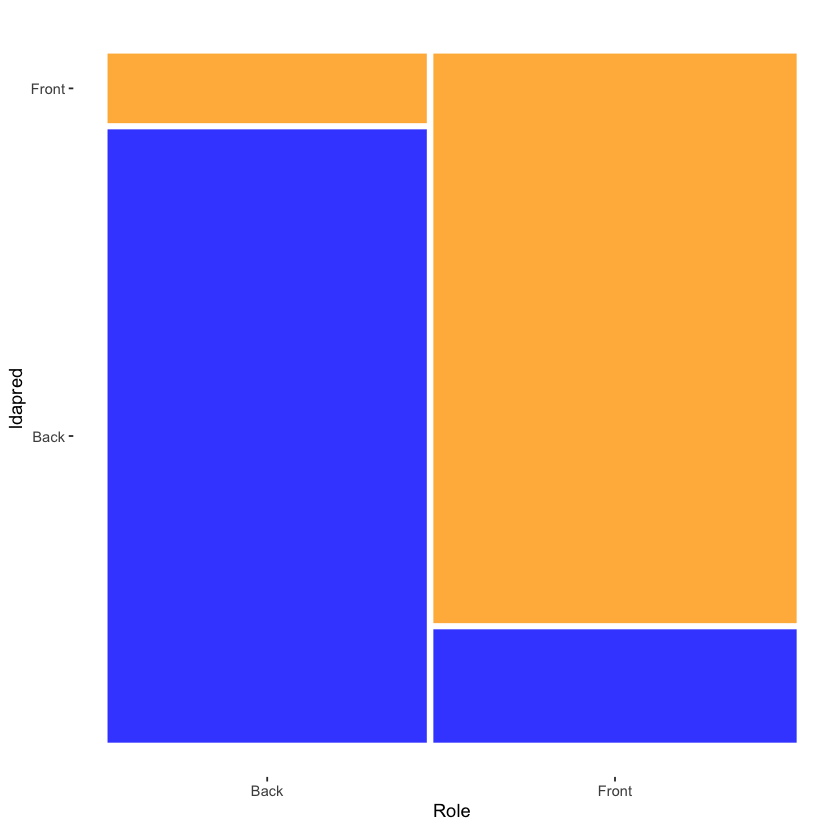

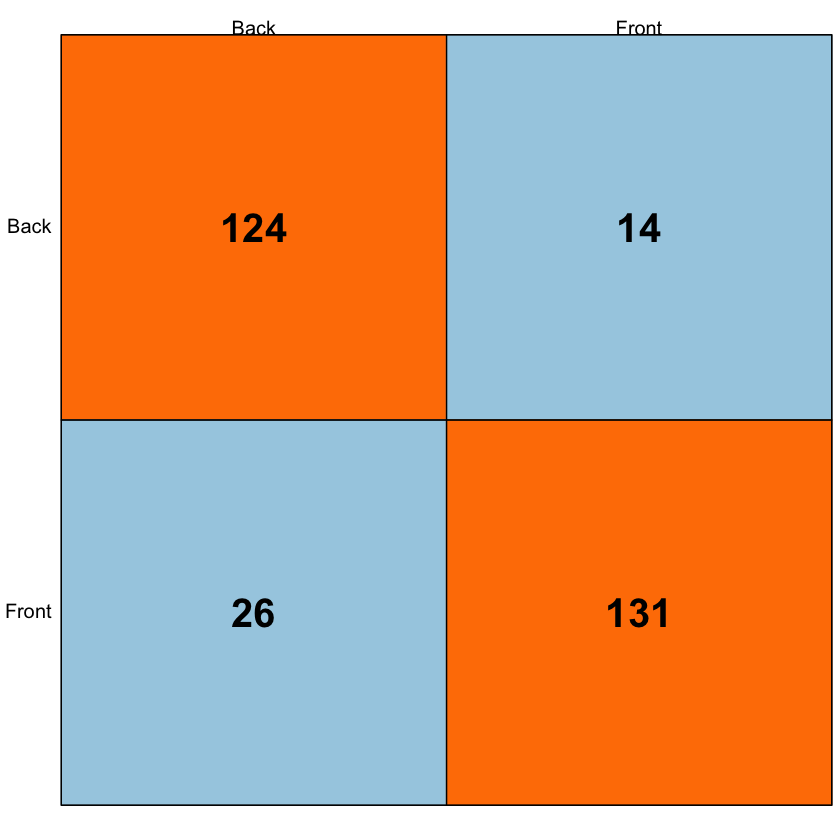

In [74]:
# mosaic plot
library(ggplot2)
library(corrplot)
library(RColorBrewer)
install.packages('ggmosaic')
library(ggmosaic)
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(ldapred, Role), fill = ldapred)) +
  labs(y="ldapred", x="Role") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Role, ldapred)
corrplot(table(validation_data$Role, ldapred), col = brewer.pal(8, 'Paired'), is.corr = F, method = 'color', tl.srt = 0, tl.col = 'black', addgrid.col = 'black', addCoef.col = 'black', number.cex = 2, cl.pos = 'n')

In [75]:
# train QDA
output.qda <- qda(Role ~ ., data = training_data)
output.qda
qdapred <- predict(output.qda, newdata = validation_data)$class

Call:
qda(Role ~ ., data = training_data)

Prior probabilities of groups:
     Back     Front 
0.4672686 0.5327314 

Group means:
           Age       MP        X3P        X2P         FT         ORB       DRB
Back  1.271410 15.61489 -0.9705961 -0.4722177 -0.1948157 -0.86232027 0.7735654
Front 1.271843 15.17158 -1.2269415 -0.4308221 -0.2226587 -0.02065764 1.3549446
            AST        STL        BLK         TOV        PF   Salary
Back  0.7781365 -0.3686649 -1.4196212  0.10445511 0.6227801 14.98716
Front 0.1970099 -0.5203294 -0.7207585 -0.01586564 0.8873154 15.25026

       qdapred
        Back Front
  Back   123    15
  Front   33   124

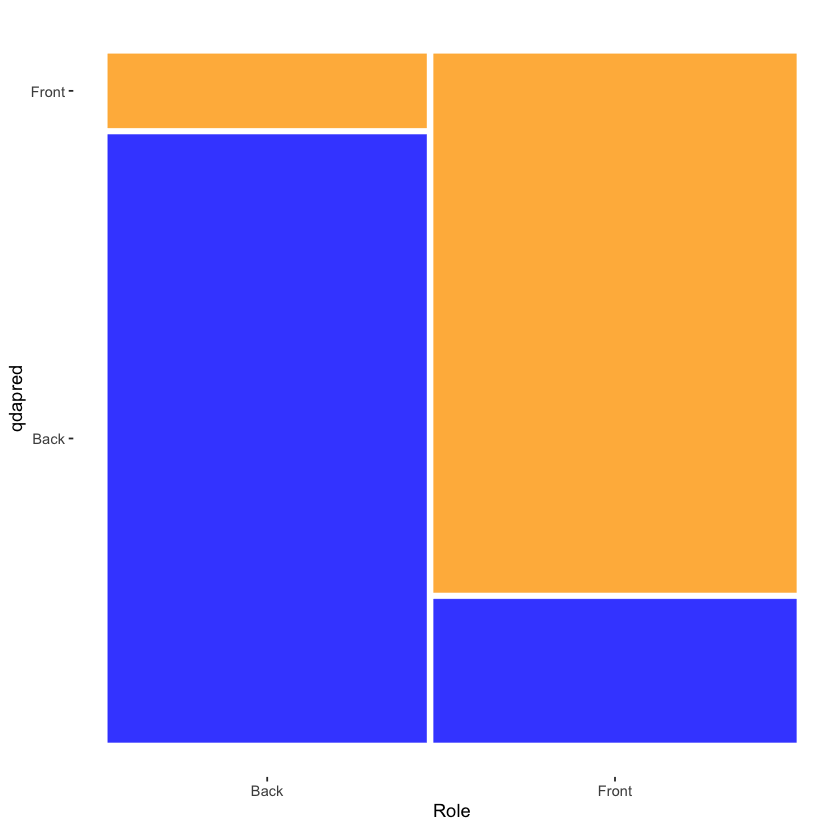

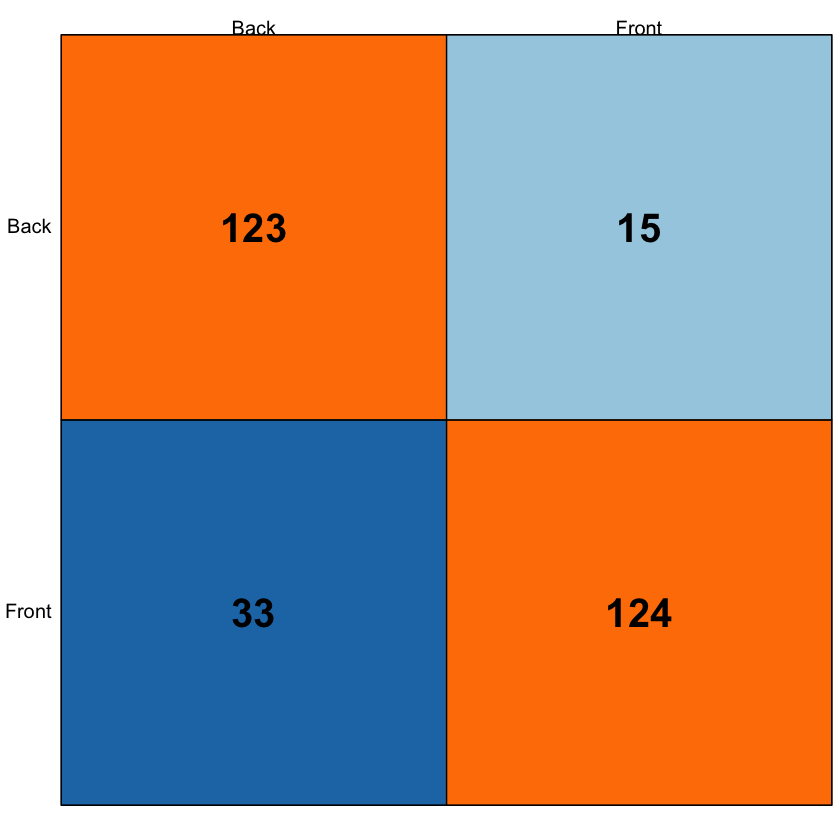

In [76]:
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(qdapred, Role), fill = qdapred)) +
  labs(y="qdapred", x="Role") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Role, qdapred)
corrplot(table(validation_data$Role, qdapred), col = brewer.pal(8, 'Paired'), is.corr = F, method = 'color', tl.srt = 0, tl.col = 'black', addgrid.col = 'black', addCoef.col = 'black', number.cex = 2, cl.pos = 'n')
# lda performs slightly better than qda

In [77]:
# k-nn classifier
library(class)
training_control <- trainControl(method = "repeatedcv",
                                 summaryFunction = defaultSummary,
                                 classProbs = TRUE,
                                 number = 10,
                                 repeats = 10)


training_data$Role <- as.factor(training_data$Role)
levels(training_data$Role) <- make.names(levels(training_data$Role))

set.seed(10)
k_values <- seq(1, 151, by = 2)
accuracy_df <- data.frame(k = numeric(), accuracy = numeric())
for (k in k_values) {
  ctrl <- trainControl(method = "cv", number = 10)
  model <- train(Role ~ ., data = training_data, method = "knn", trControl = ctrl, tuneGrid = data.frame(k = k))
  accuracy_df <- rbind(accuracy_df, data.frame(k = k, accuracy = model$results$Accuracy))
}

optimal_k <- accuracy_df$k[which.max(accuracy_df$accuracy)]
cat("Optimal k:", optimal_k, "\n")

Optimal k: 57 


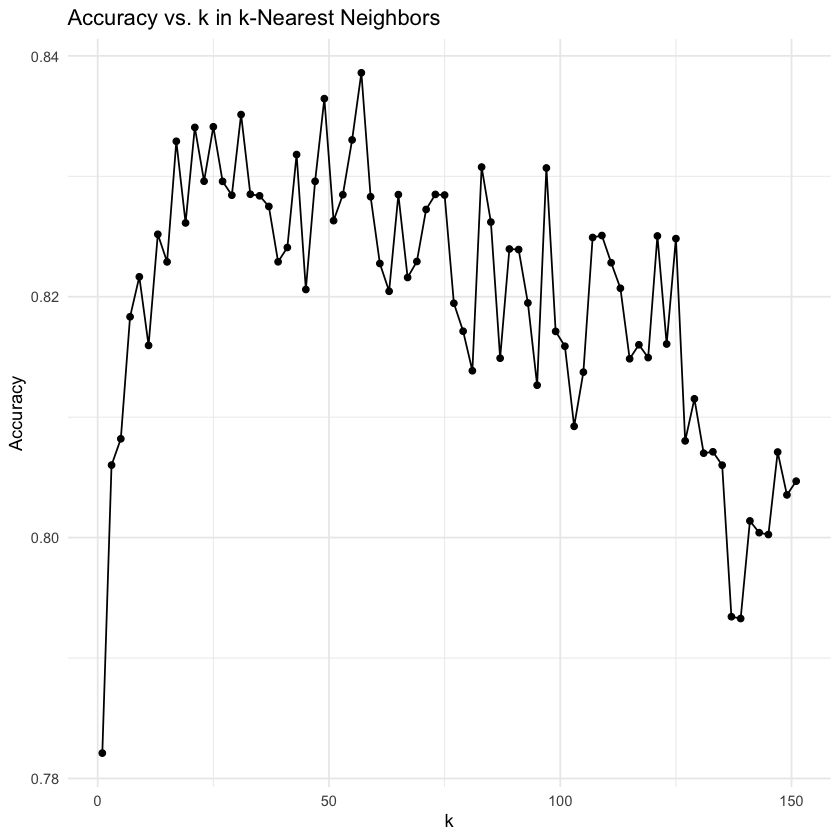

In [78]:
# plot accuracy vs k
ggplot(accuracy_df, aes(x = k, y = accuracy)) +
  geom_line() +
  geom_point() +
  labs(x = "k", y = "Accuracy") +
  ggtitle("Accuracy vs. k in k-Nearest Neighbors") +
  theme_minimal()

       knn_3
        Back Front
  Back   123    15
  Front   39   118

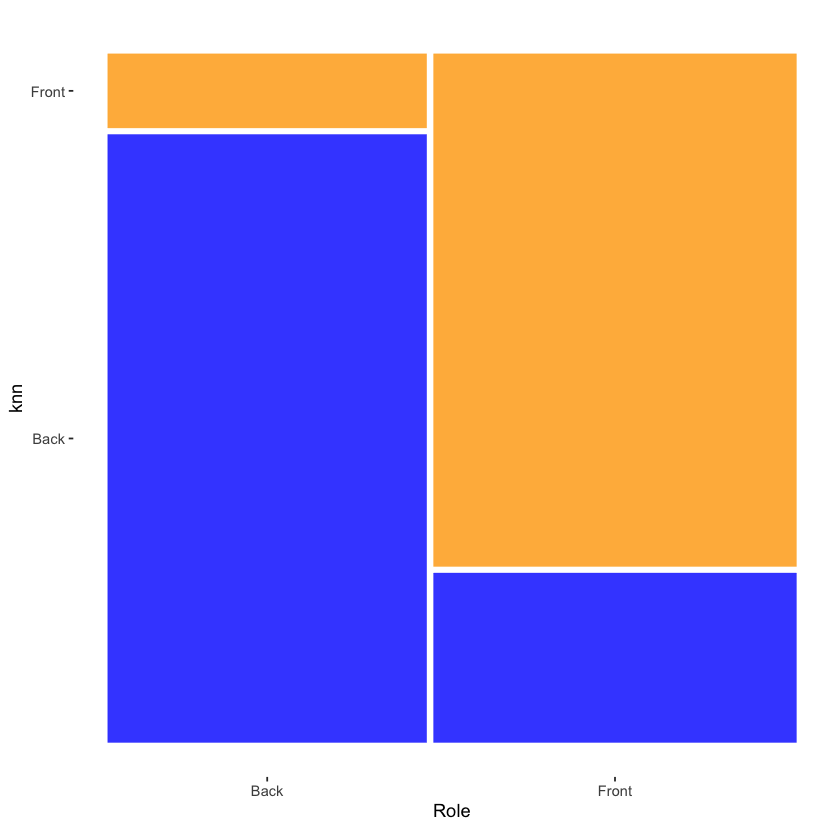

In [79]:
x2 <- validation_data[,-c(1)]
knn_3 <- knn(train = training_data[, -c(1)], test = x2, cl = training_data$Role, k = optimal_k)

# confusion matrix
table(validation_data$Role, knn_3)
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(knn_3, Role), fill = knn_3)) +
  labs(y="knn", x="Role") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class

In [80]:
# ROC curve
library(caret)
library(pROC)

par(mfrow = c(1, 1))

knn_probs <- knn(train = training_data[, -c(1)], test = validation_data[, -c(1)], cl = training_data$Role, k = optimal_k, prob = T)
prob <- attr(knn_probs, "prob")
roc_curve.knn <- roc(validation_data$Role, prob)

# Create ROC curve
roc_curve.knn <- roc(validation_data$Role, prob)
ldapred_probs <- predict(output.lda, newdata = validation_data[, -1], type = "response")$posterior[, 2]
roc_curve.lda <- roc(validation_data$Role, ldapred_probs)
qdapred_probs <- predict(output.qda, newdata = validation_data[, -1], type = 'response')$posterior[, 2]
roc_curve.qda <- roc(validation_data$Role, qdapred_probs)

# AUC scores
auc_knn <- auc(roc_curve.knn)
auc_lda <- auc(roc_curve.lda)
auc_qda <- auc(roc_curve.qda)
cat("AUC for k-NN:", auc_knn, "\n")
cat("AUC for LDA:", auc_lda, "\n")
cat("AUC for QDA:", auc_qda, "\n")

Setting levels: control = Back, case = Front

Setting direction: controls < cases

Setting levels: control = Back, case = Front

Setting direction: controls < cases

Setting levels: control = Back, case = Front

Setting direction: controls < cases

Setting levels: control = Back, case = Front

Setting direction: controls < cases



AUC for k-NN: 0.5423475 
AUC for LDA: 0.9441521 
AUC for QDA: 0.9304902 


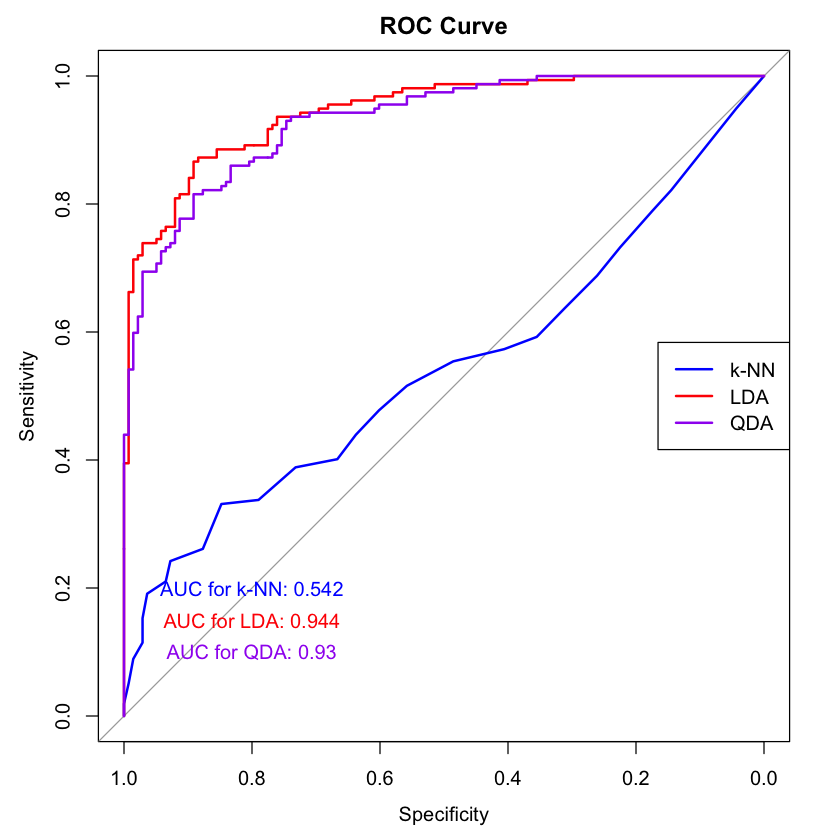

In [81]:
# plot ROC curves
plot(roc_curve.knn, main = "ROC Curve", col = "blue", lwd = 2)
lines(roc_curve.lda, col = 'red')
lines(roc_curve.qda, col = 'purple')
legend("right", legend = c("k-NN", "LDA", "QDA"), col = c("blue", "red", "purple"), lty = 1, lwd = 2)
text(0.8, 0.2, paste("AUC for k-NN:", round(auc_knn, 3)), col = "blue")
text(0.8, 0.15, paste("AUC for LDA:", round(auc_lda, 3)), col = "red")
text(0.8, 0.1, paste("AUC for QDA:", round(auc_qda, 3)), col = "purple")

We know classify Pos1 based on the same classifiers. In this case, QDA performs slightly better than LDA.

In [82]:
# predict Pos1

players.continuous <- players.trans[-c(1, 2, 4)]

# split training/validation
set.seed(40)
split_index <- createDataPartition(players.continuous$Pos1, p = 0.75, list = F)
training_data <- players.continuous[split_index, ]
validation_data <- players.continuous[-split_index, ]


# train LDA
output.lda <- lda(Pos1 ~ ., data = training_data)
output.lda
ldapred <- predict(output.lda, newdata = validation_data)$class

Call:
lda(Pos1 ~ ., data = training_data)

Prior probabilities of groups:
        C        PF        PG        SF        SG 
0.1677928 0.2128378 0.2060811 0.1722973 0.2409910 

Group means:
        Age       MP        X3P        X2P         FT        ORB       DRB
C  1.273564 14.60862 -1.6498712 -0.4002711 -0.2413773  0.4321292 1.5975776
PF 1.271109 14.40079 -1.0824581 -0.4376337 -0.2243092 -0.1199788 1.2668304
PG 1.271804 15.38077 -1.0148522 -0.4777425 -0.1846909 -0.9080165 0.7416987
SF 1.273874 15.84104 -0.9675548 -0.4518385 -0.2164846 -0.5502063 1.0612749
SG 1.271588 15.79875 -0.9065710 -0.4664503 -0.1896832 -0.8777644 0.7764029
          AST        STL        BLK         TOV        PF   Salary
C  0.20183210 -0.5893939 -0.2544100  0.09806475 1.1329128 15.46041
PF 0.03959564 -0.6486110 -0.8971447 -0.10851709 0.7610861 15.11540
PG 1.22718204 -0.2920967 -1.5323222  0.30981602 0.6336590 14.94180
SF 0.28554200 -0.3615634 -1.0914754 -0.10548378 0.6674467 15.07979
SG 0.47792594 -0.4349187 

    ldapred
      C PF PG SF SG
  C  38 11  0  0  0
  PF  7 43  0 10  3
  PG  1  1 47  2  9
  SF  1 13  1 23 12
  SG  0  4  9 11 47

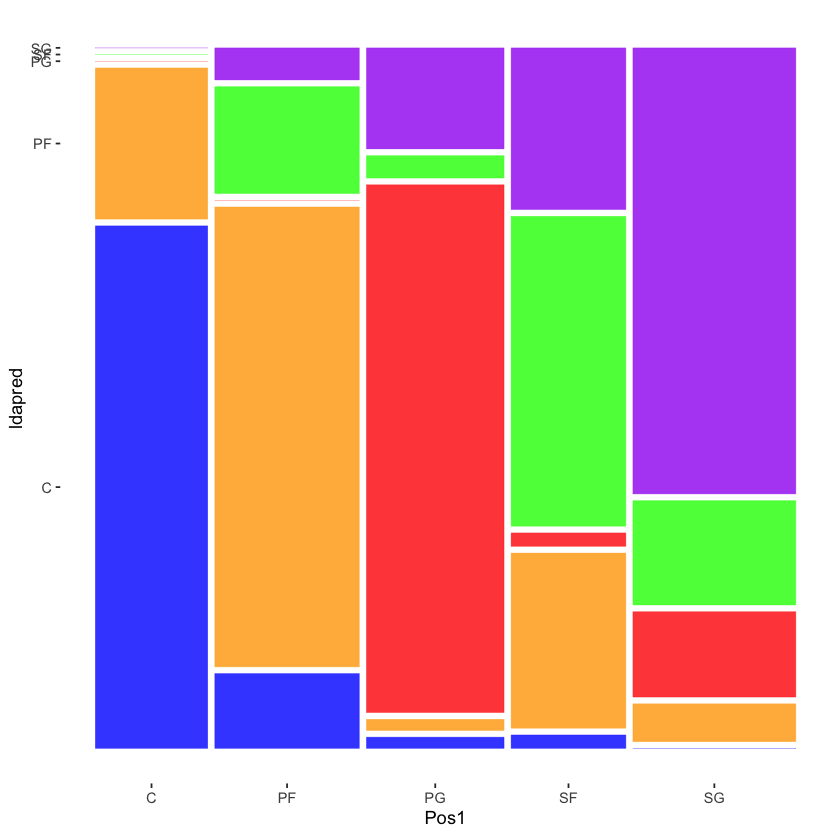

In [83]:
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange", 'red', 'green', 'purple')) +
  geom_mosaic(aes(x = product(ldapred, Pos1), fill = ldapred)) +
  labs(y="ldapred", x="Pos1") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Pos1, ldapred)

In [84]:
# train QDA
output.qda <- qda(Pos1 ~ ., data = training_data)
output.qda
qdapred <- predict(output.qda, newdata = validation_data)$class

Call:
qda(Pos1 ~ ., data = training_data)

Prior probabilities of groups:
        C        PF        PG        SF        SG 
0.1677928 0.2128378 0.2060811 0.1722973 0.2409910 

Group means:
        Age       MP        X3P        X2P         FT        ORB       DRB
C  1.273564 14.60862 -1.6498712 -0.4002711 -0.2413773  0.4321292 1.5975776
PF 1.271109 14.40079 -1.0824581 -0.4376337 -0.2243092 -0.1199788 1.2668304
PG 1.271804 15.38077 -1.0148522 -0.4777425 -0.1846909 -0.9080165 0.7416987
SF 1.273874 15.84104 -0.9675548 -0.4518385 -0.2164846 -0.5502063 1.0612749
SG 1.271588 15.79875 -0.9065710 -0.4664503 -0.1896832 -0.8777644 0.7764029
          AST        STL        BLK         TOV        PF   Salary
C  0.20183210 -0.5893939 -0.2544100  0.09806475 1.1329128 15.46041
PF 0.03959564 -0.6486110 -0.8971447 -0.10851709 0.7610861 15.11540
PG 1.22718204 -0.2920967 -1.5323222  0.30981602 0.6336590 14.94180
SF 0.28554200 -0.3615634 -1.0914754 -0.10548378 0.6674467 15.07979
SG 0.47792594 -0.4349187 

    qdapred
      C PF PG SF SG
  C  34 14  0  1  0
  PF  9 40  0 10  4
  PG  1  2 42  2 13
  SF  1  6  0 27 16
  SG  0  4  7 14 46

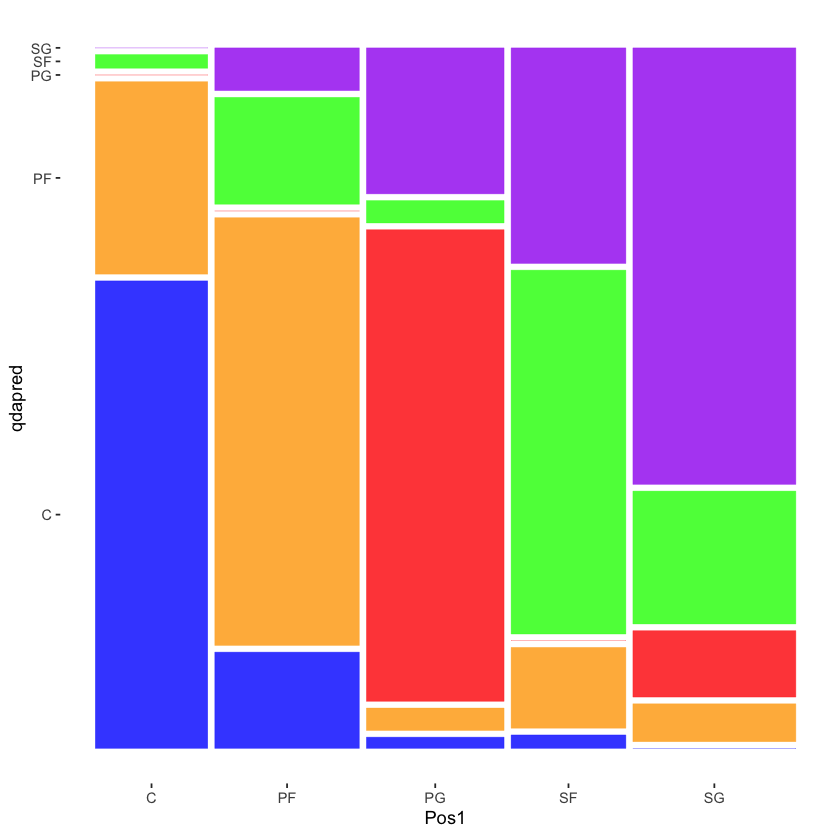

In [85]:
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange", 'red', 'green', 'purple')) +
  geom_mosaic(aes(x = product(qdapred, Pos1), fill = qdapred)) +
  labs(y="qdapred", x="Pos1") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Pos1, qdapred)

In [86]:
# k-nn classifier
set.seed(10)
k_values <- seq(1, 151, by = 2)
accuracy_df <- data.frame(k = numeric(), accuracy = numeric())
for (k in k_values) {
  ctrl <- trainControl(method = "cv", number = 10)
  model <- train(Pos1 ~ ., data = training_data, method = "knn", trControl = ctrl, tuneGrid = data.frame(k = k))
  accuracy_df <- rbind(accuracy_df, data.frame(k = k, accuracy = model$results$Accuracy))
}

optimal_k <- accuracy_df$k[which.max(accuracy_df$accuracy)]

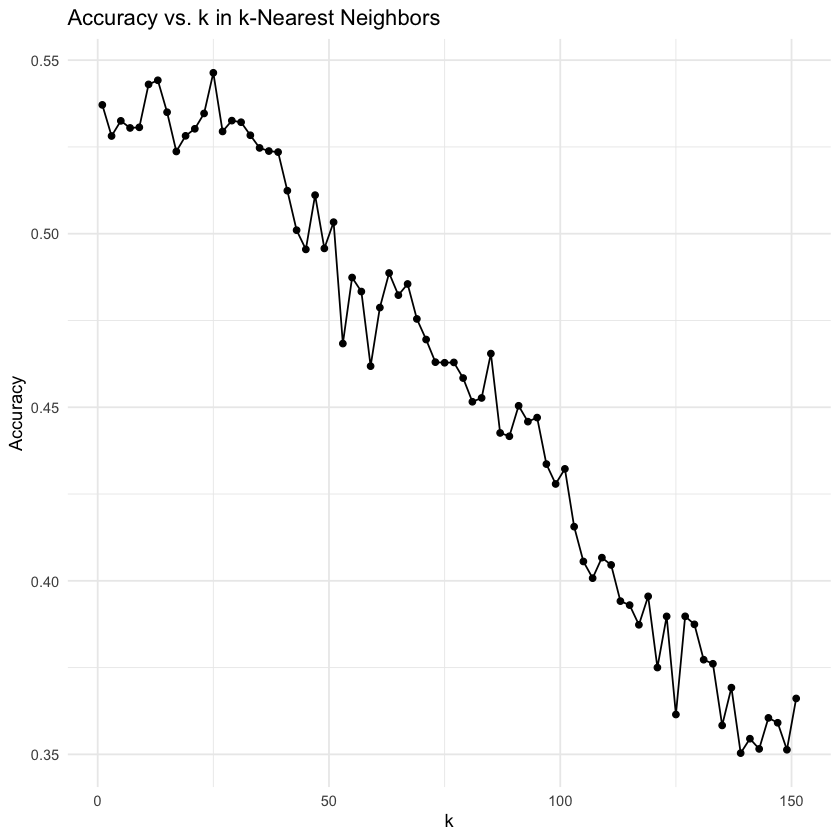

In [87]:
# plot accuracy vs k
ggplot(accuracy_df, aes(x = k, y = accuracy)) +
  geom_line() +
  geom_point() +
  labs(x = "k", y = "Accuracy") +
  ggtitle("Accuracy vs. k in k-Nearest Neighbors") +
  theme_minimal()

[1] 293

    knn_3
      C PF PG SF SG
  C  30 17  0  2  0
  PF  8 40  2  8  5
  PG  1  2 39  0 18
  SF  0 14  1  5 30
  SG  0 10 10  4 47

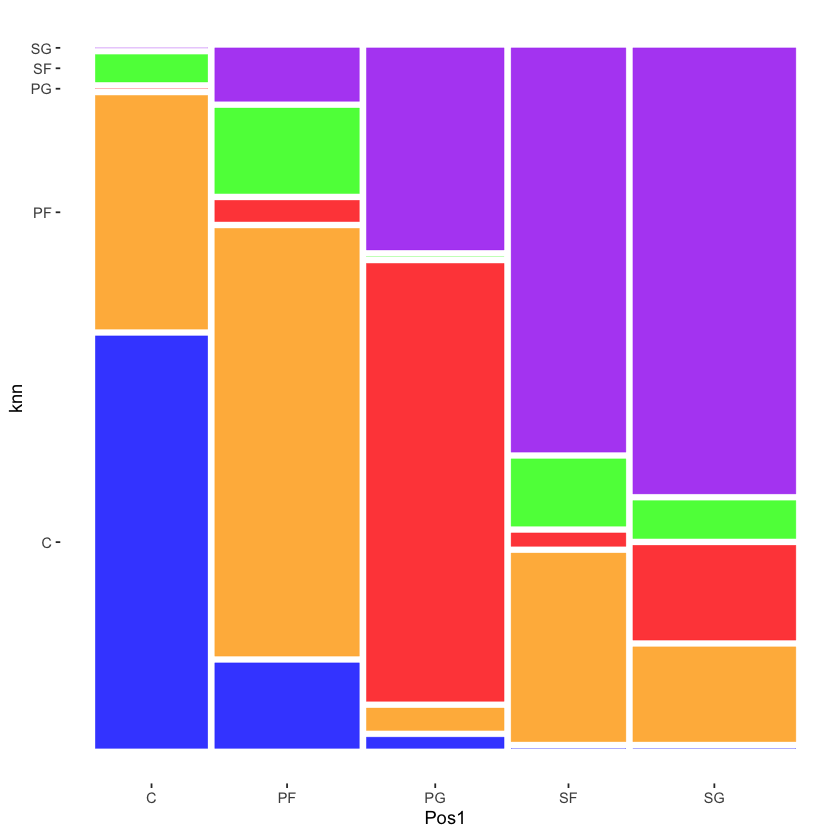

In [88]:
x2 <- validation_data[,-c(1)]
validation_data$Pos1 <- as.factor(validation_data$Pos1)
levels(validation_data$Pos1) <- make.names(levels(validation_data$Pos1))
knn_3 = knn(train = training_data[, -c(1)], test = x2, cl = training_data$Pos1, k = optimal_k)
length(knn_3)
# confusion matrix
table(validation_data$Pos1, knn_3)
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange", 'red', 'green', 'purple')) +
  geom_mosaic(aes(x = product(knn_3, Pos1), fill = knn_3)) +
  labs(y="knn", x="Pos1") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class

In [89]:
# ROC curve
knn_probs = knn(train = training_data[, -c(1)], test = validation_data[, -c(1)], cl = training_data$Pos1, k = optimal_k, prob = T)
prob <- attr(knn_probs, "prob")
roc_curve.knn <- roc(validation_data$Pos1, prob)
ldapred_probs <- predict(output.lda, newdata = validation_data[, -1], type = "response")$posterior[, 2]
roc_curve.lda <- roc(validation_data$Pos1, ldapred_probs)
qdapred_probs <- predict(output.qda, newdata = validation_data[, -1], type = 'response')$posterior[, 2]
roc_curve.qda <- roc(validation_data$Pos1, qdapred_probs)

# AUC scores
auc_knn <- auc(roc_curve.knn)
auc_lda <- auc(roc_curve.lda)
auc_qda <- auc(roc_curve.qda)
cat("AUC for k-NN:", auc_knn, "\n")
cat("AUC for LDA:", auc_lda, "\n")
cat("AUC for QDA:", auc_qda, "\n")

Warning message in roc.default(validation_data$Pos1, prob):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = C, case = PF

Setting direction: controls > cases

Warning message in roc.default(validation_data$Pos1, ldapred_probs):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = C, case = PF

Setting direction: controls < cases

Warning message in roc.default(validation_data$Pos1, qdapred_probs):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = C, case = PF

Setting direction: controls < cases



AUC for k-NN: 0.7317784 
AUC for LDA: 0.7589893 
AUC for QDA: 0.7573696 


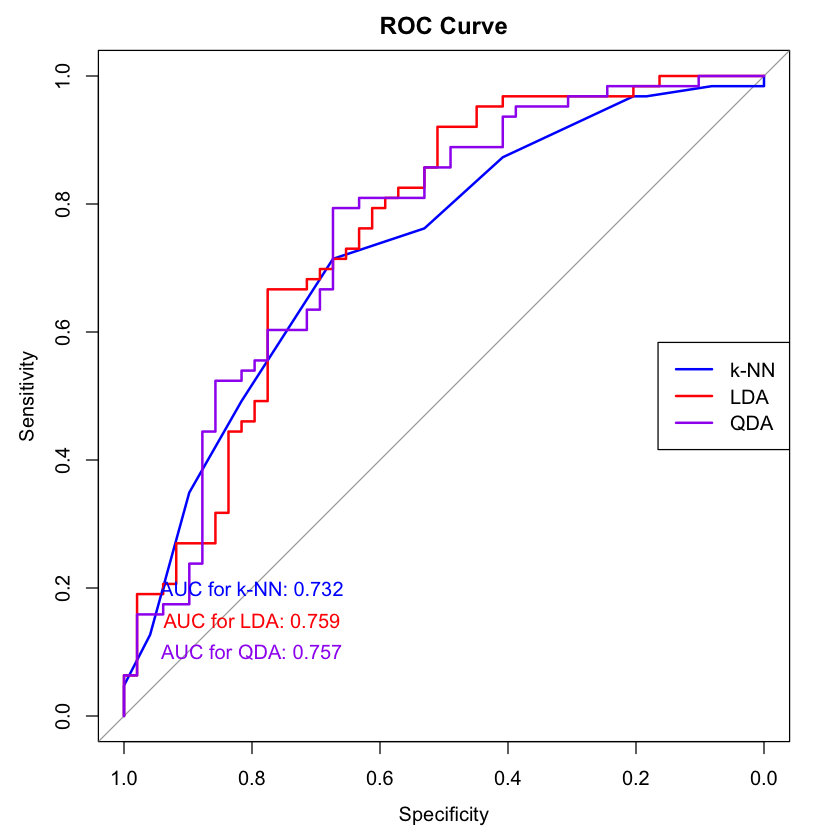

In [90]:
plot(roc_curve.knn, main = "ROC Curve", col = "blue", lwd = 2)
lines(roc_curve.lda, col = 'red')
lines(roc_curve.qda, col = 'purple')
legend("right", legend = c("k-NN", "LDA", "QDA"), col = c("blue", "red", "purple"), lty = 1, lwd = 2)
text(0.8, 0.2, paste("AUC for k-NN:", round(auc_knn, 3)), col = "blue")
text(0.8, 0.15, paste("AUC for LDA:", round(auc_lda, 3)), col = "red")
text(0.8, 0.1, paste("AUC for QDA:", round(auc_qda, 3)), col = "purple")

Finally, we predict Play, based on the same classifiers. In this case, LDA performs better than the other classifiers, as indicated by the ROC curve, since the variable has two very unbalanced classes.

In [91]:
# predict Play
players.continuous <- players.trans[-c(1, 3, 4)]

# split training/validation
set.seed(40)
split_index <- createDataPartition(players.continuous$Play, p = 0.75, list = F)
training_data <- players.continuous[split_index, ]
validation_data <- players.continuous[-split_index, ]

# train LDA
output.lda <- lda(Play ~ ., data = training_data)
output.lda
ldapred <- predict(output.lda, newdata = validation_data)$class

Call:
lda(Play ~ ., data = training_data)

Prior probabilities of groups:
        No        Yes 
0.93792325 0.06207675 

Group means:
         Age       MP       X3P        X2P         FT        ORB       DRB
No  1.271109 14.73449 -1.101310 -0.4514029 -0.2131372 -0.4857673 0.9953219
Yes 1.277329 23.42567 -1.017171 -0.4289628 -0.1749896  0.1331062 2.1291083
          AST        STL       BLK         TOV       PF   Salary
No  0.3712616 -0.5021967 -1.125345 -0.03147398 0.723947 15.02902
Yes 1.6747972  0.1782969 -0.353586  1.10063148 1.288462 16.74593

Coefficients of linear discriminants:
                LD1
Age     1.727724527
MP      0.004292031
X3P    -0.051090938
X2P     3.409657902
FT      1.184339828
ORB    -0.236004913
DRB     0.739341584
AST    -0.051389098
STL     0.154523112
BLK     0.146267772
TOV     1.205214117
PF     -0.909046123
Salary  0.180707005

     ldapred
       No Yes
  No  277   0
  Yes  11   7

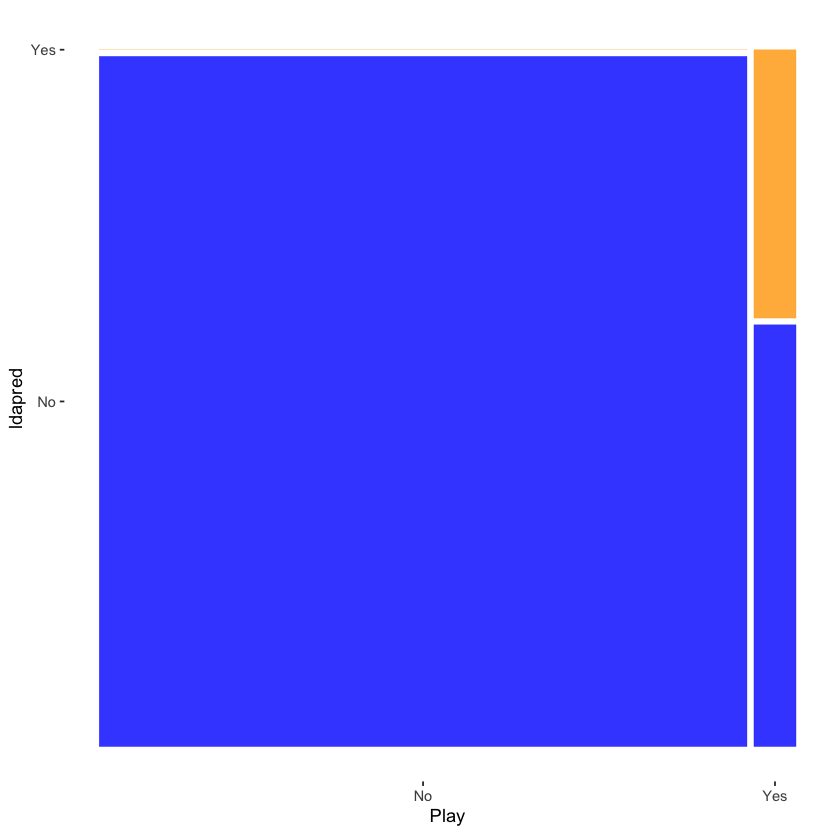

In [92]:
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(ldapred, Play), fill = ldapred)) +
  labs(y="ldapred", x="Play") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Play, ldapred)

In [93]:
# train QDA
output.qda <- qda(Play ~ ., data = training_data)
output.qda
qdapred <- predict(output.qda, newdata = validation_data)$class

Call:
qda(Play ~ ., data = training_data)

Prior probabilities of groups:
        No        Yes 
0.93792325 0.06207675 

Group means:
         Age       MP       X3P        X2P         FT        ORB       DRB
No  1.271109 14.73449 -1.101310 -0.4514029 -0.2131372 -0.4857673 0.9953219
Yes 1.277329 23.42567 -1.017171 -0.4289628 -0.1749896  0.1331062 2.1291083
          AST        STL       BLK         TOV       PF   Salary
No  0.3712616 -0.5021967 -1.125345 -0.03147398 0.723947 15.02902
Yes 1.6747972  0.1782969 -0.353586  1.10063148 1.288462 16.74593

     qdapred
       No Yes
  No  267  10
  Yes   5  13

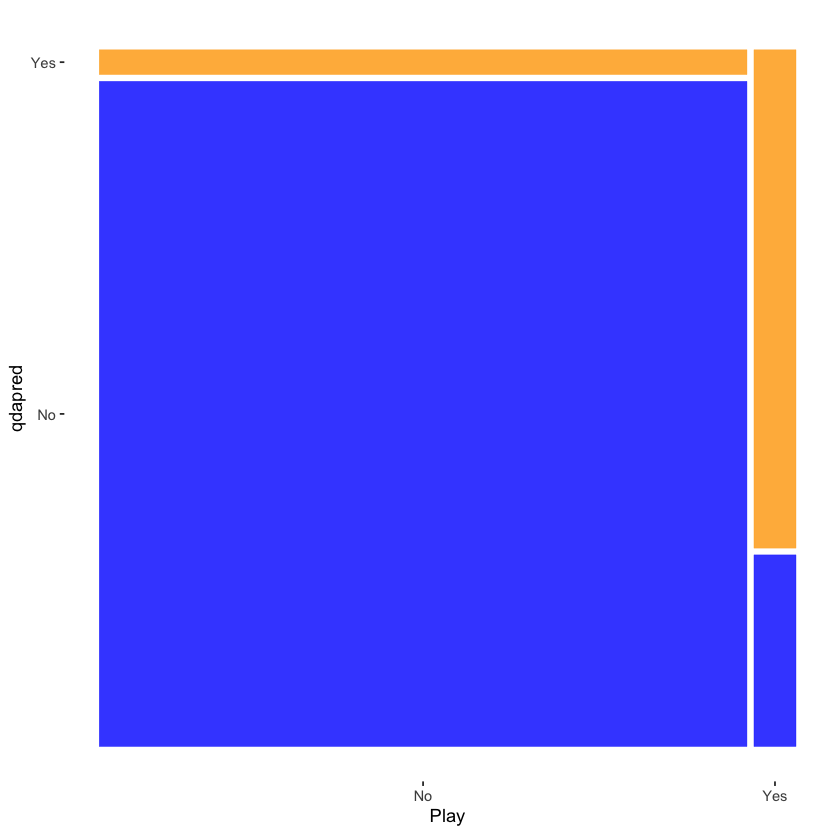

In [94]:
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(qdapred, Play), fill = qdapred)) +
  labs(y="qdapred", x="Play") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class
# confusion matrix
table(validation_data$Play, qdapred)

In [95]:
# knn
training_data$Play <- as.factor(training_data$Play)
levels(training_data$Play) <- make.names(levels(training_data$Play))

set.seed(10)
k_values <- seq(1, 151, by = 2)
accuracy_df <- data.frame(k = numeric(), accuracy = numeric())
for (k in k_values) {
  ctrl <- trainControl(method = "cv", number = 10, classProbs = T)
  model <- train(Play ~ ., data = training_data, method = "knn", trControl = ctrl, tuneGrid = data.frame(k = k))
  accuracy_df <- rbind(accuracy_df, data.frame(k = k, accuracy = model$results$Accuracy))
}

optimal_k <- accuracy_df$k[which.max(accuracy_df$accuracy)]

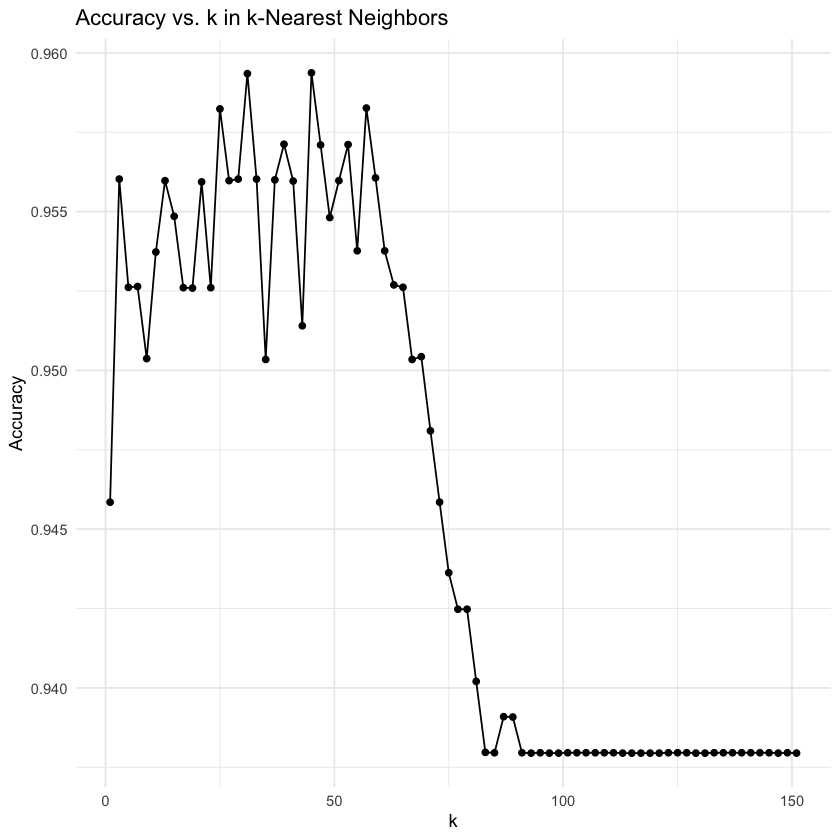

In [96]:
# plot accuracy vs k
ggplot(accuracy_df, aes(x = k, y = accuracy)) +
  geom_line() +
  geom_point() +
  labs(x = "k", y = "Accuracy") +
  ggtitle("Accuracy vs. k in k-Nearest Neighbors") +
  theme_minimal()

     knn_3
       No Yes
  No  274   3
  Yes  14   4

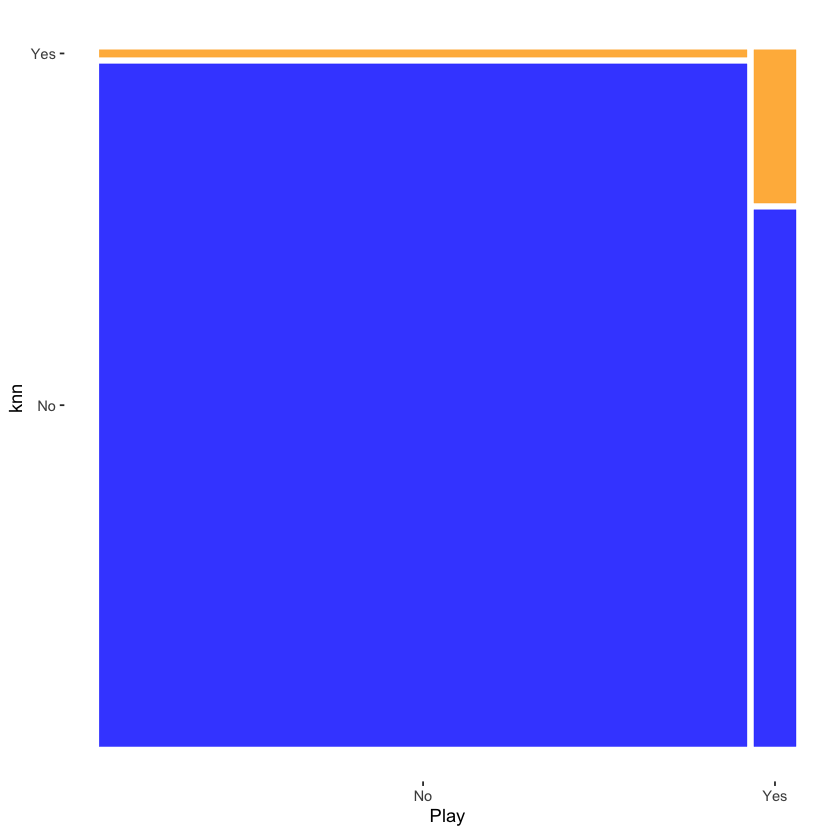

In [97]:
x2 <- validation_data[,-c(1)]
knn_3 = knn(train = training_data[, -c(1)], test = x2, cl = training_data$Play, k = optimal_k)

# confusion matrix
table(validation_data$Play, knn_3)
# mosaic plot
mosaic_class <- ggplot(data = validation_data) +
  scale_fill_manual(values=c("blue", "orange")) +
  geom_mosaic(aes(x = product(knn_3, Play), fill = knn_3)) +
  labs(y="knn", x="Play") +
  theme_mosaic() +
  theme(legend.position='none')
mosaic_class

In [98]:
# ROC curve
knn_probs = knn(train = training_data[, -c(1)], test = validation_data[, -c(1)], cl = training_data$Play, k = optimal_k, prob = T)
prob <- attr(knn_probs, "prob")
roc_curve.knn <- roc(validation_data$Play, prob)
ldapred_probs <- predict(output.lda, newdata = validation_data[, -1], type = "response")$posterior[, 2]
roc_curve.lda <- roc(validation_data$Play, ldapred_probs)
qdapred_probs <- predict(output.qda, newdata = validation_data[, -1], type = 'response')$posterior[, 2]
roc_curve.qda <- roc(validation_data$Play, qdapred_probs)

# AUC scores
auc_knn <- auc(roc_curve.knn)
auc_lda <- auc(roc_curve.lda)
auc_qda <- auc(roc_curve.qda)
cat("AUC for k-NN:", auc_knn, "\n")
cat("AUC for LDA:", auc_lda, "\n")
cat("AUC for QDA:", auc_qda, "\n")

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases



AUC for k-NN: 0.9356197 
AUC for LDA: 0.9737264 
AUC for QDA: 0.9398315 


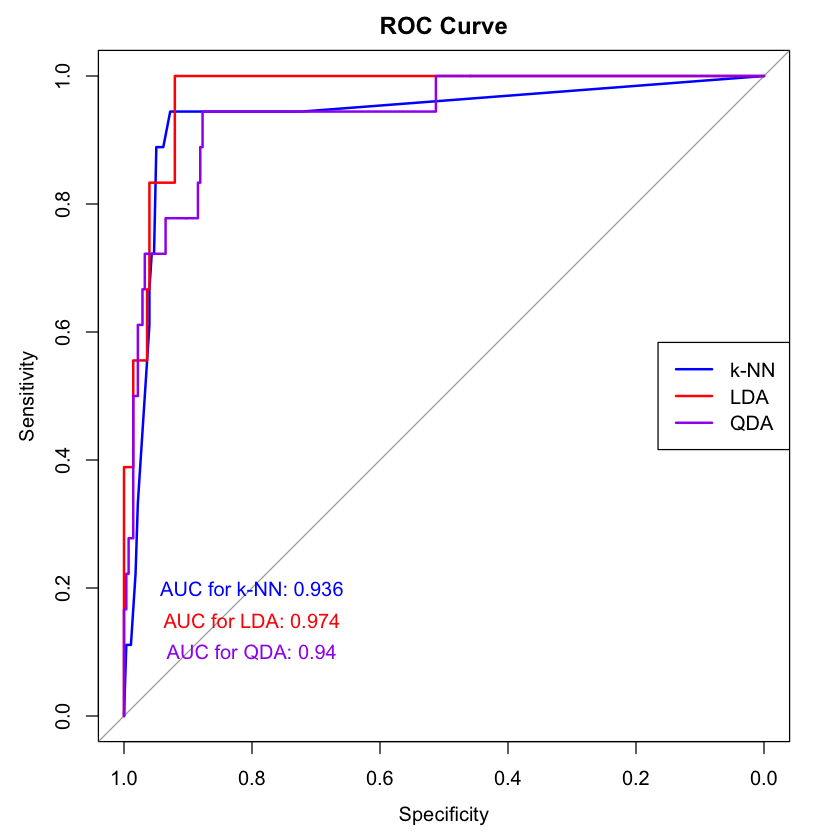

In [99]:
plot(roc_curve.knn, main = "ROC Curve", col = "blue", lwd = 2)
lines(roc_curve.lda, col = 'red')
lines(roc_curve.qda, col = 'purple')
legend("right", legend = c("k-NN", "LDA", "QDA"), col = c("blue", "red", "purple"), lty = 1, lwd = 2)
text(0.8, 0.2, paste("AUC for k-NN:", round(auc_knn, 3)), col = "blue")
text(0.8, 0.15, paste("AUC for LDA:", round(auc_lda, 3)), col = "red")
text(0.8, 0.1, paste("AUC for QDA:", round(auc_qda, 3)), col = "purple")
# with Play as target variable, LDA is the best classifier
# the classes of Play are imbalanced